In [48]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import preprocessing

In [49]:
df = pd.read_csv('../../Data/CSV-files/dataset-of-00sv2.csv')
#df = pd.read_csv('../../Data/CSV-files/dataset-of-90sv2.csv')
#df = pd.read_csv('../../Data/CSV-files/dataset-of-60sv2.csv')
df.head(1)

,track,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,...,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target,artist_popularity,artist_followers
0,Lucky Man,Montgomery Gentry,spotify:track:4GiXBCUF7H6YfNQsnBRIzl,0.578,0.471,4,-7.27,1,0.0289,0.368,...,0.159,0.532,133.061,196707,4,30.88059,13,1,63,973747


In [50]:
def sort_data(dataframe):
    return dataframe.sample(frac=1)

def remove_data(dataframe,list):
    return dataframe.drop(list,axis=1,inplace=True)

def remove_column(dataframe,columnName):
    return dataframe.loc[:,dataframe.columns != columnName]

def get_column(dataframe,columnNr):
    return dataframe.iloc[:,[columnNr]]

In [51]:
#Sorterer dataen og tar bort kolonner
data = sort_data(df)
remove_data(data,["track","artist","uri"])

#Henter ut targetverdiene til egen dataframe
target = get_column(data,15)

#Fjerner kolonnen target
unscaled_inputs = remove_column(data,'target')

#Skaler dataen, samler verdier rundt 0
scaled_inputs = preprocessing.scale(unscaled_inputs)
#scaled_inputs er typen array 

In [52]:
#Henter ut alle rader, og alle kollonner fra kol: 0 til og med nest siste 
#columns_dont_want = ["target"]
#select = [x for x in data.columns if x not in columns_dont_want]
#unscaled_inputs = data.iloc[:,select]

In [53]:
samples_count = scaled_inputs.shape[0]

train_samples_count = int(0.8*samples_count)
validation_samples_count = int(0.1*samples_count)
test_samples_count = samples_count - train_samples_count - validation_samples_count

In [54]:
#Listeopersjoner på scaled_inputs og target, deler dataen inn i trening, validering og test - datasett

train_inputs = scaled_inputs[:train_samples_count]
train_targets = target[:train_samples_count]

validation_inputs = scaled_inputs[train_samples_count:train_samples_count+validation_samples_count]
validation_targets = target[train_samples_count:train_samples_count+validation_samples_count]

test_inputs = scaled_inputs[train_samples_count+validation_samples_count:]
test_targets = target[train_samples_count+validation_samples_count:]

In [55]:
print("Training \n" ,np.sum(train_targets), train_samples_count, np.sum(train_targets) / train_samples_count,"\n")
print("Validation \n",np.sum(validation_targets), validation_samples_count, np.sum(validation_targets) / validation_samples_count,"\n")
print("Test \n",np.sum(test_targets), test_samples_count, np.sum(test_targets) / test_samples_count)

Training 
 target    2352
dtype: int64 4697 target    0.500745
dtype: float64 

Validation 
 target    305
dtype: int64 587 target    0.519591
dtype: float64 

Test 
 target    279
dtype: int64 588 target    0.47449
dtype: float64


In [56]:
#Hvorfor lagre det som fil og hente ut verdier slik det gjøre i denne og neste blokk?
np.savez('Spotify_data_train', inputs=train_inputs, targets=train_targets)
np.savez('Spotify_data_validation', inputs=validation_inputs, targets=validation_targets)
np.savez('Spotify_data_test', inputs=test_inputs, targets=test_targets)

In [57]:
npz = np.load('Spotify_data_train.npz')
#Henter ut fra filer med navnet vi lagret det med over
train_inputs = npz['inputs'].astype(np.float)
train_targets = npz['targets'].astype(np.int)

npz = np.load('Spotify_data_validation.npz')
validation_inputs, validation_targets = npz['inputs'].astype(np.float), npz['targets'].astype(np.int)

npz = np.load('Spotify_data_test.npz')
test_inputs, test_targets = npz['inputs'].astype(np.float), npz['targets'].astype(np.int)

In [58]:
# Set the input and output sizes
input_size = 17 # count of features
output_size = 2 # count of targets
# Use same hidden layer size for both hidden layers. Not a necessity.
hidden_layer_size = 50 # counts of neurons

# define how the model will look like
#Stacker ulike lak med hidden layer "oppå" hverandre i modellen 
model = tf.keras.Sequential([
    # tf.keras.layers.Dense is basically implementing: output = activation(dot(input, weight) + bias)
    # it takes several arguments, but the most important ones for us are the hidden_layer_size and the activation function
    tf.keras.layers.Dense(hidden_layer_size, activation='relu'), # 1st hidden layer
    tf.keras.layers.Dense(hidden_layer_size, activation='relu'), # 2nd hidden layer
    tf.keras.layers.Dense(hidden_layer_size, activation='relu'), # 3nd hidden layer
    # the final layer is no different, we just make sure to activate it with softmax
    tf.keras.layers.Dense(output_size, activation='softmax') # output layer
])

In [59]:
#SJEKK HVA DE ULIKE HER GJØR, PRØV FORSKJELLIGE 
#Optimizer er gradient descent?

# we define the optimizer we'd like to use, 
# the loss function, 
# and the metrics we are interested in obtaining at each iteration
#custom_optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [60]:
# That's where we train the model we have built.
# set the batch size
batch_size = 300
# set a maximum number of training epochs
max_epochs = 10

# fit the model
# note that this time the train, validation and test data are not iterable
history = model.fit(  train_inputs, # train inputs
                      train_targets, # train targets
                      batch_size=batch_size, # batch size
                      epochs=max_epochs, # epochs that we will train for (assuming early stopping doesn't kick in)
                      # callbacks are functions called by a task when a task is completed
                      # task here is to check if val_loss is increasing
                      #callbacks=[early_stopping], # early stopping
                      validation_data=(validation_inputs, validation_targets), # validation data
                      verbose = 2 # making sure we get enough information about the training process
          )  

Epoch 1/10
16/16 - 0s - loss: 0.5915 - accuracy: 0.7222 - val_loss: 0.4942 - val_accuracy: 0.8382
Epoch 2/10
16/16 - 0s - loss: 0.4157 - accuracy: 0.8557 - val_loss: 0.3425 - val_accuracy: 0.8688
Epoch 3/10
16/16 - 0s - loss: 0.3118 - accuracy: 0.8686 - val_loss: 0.2892 - val_accuracy: 0.8859
Epoch 4/10
16/16 - 0s - loss: 0.2821 - accuracy: 0.8782 - val_loss: 0.2766 - val_accuracy: 0.8927
Epoch 5/10
16/16 - 0s - loss: 0.2697 - accuracy: 0.8859 - val_loss: 0.2680 - val_accuracy: 0.8910
Epoch 6/10
16/16 - 0s - loss: 0.2613 - accuracy: 0.8938 - val_loss: 0.2670 - val_accuracy: 0.8927
Epoch 7/10
16/16 - 0s - loss: 0.2546 - accuracy: 0.8967 - val_loss: 0.2647 - val_accuracy: 0.8995
Epoch 8/10
16/16 - 0s - loss: 0.2500 - accuracy: 0.8950 - val_loss: 0.2622 - val_accuracy: 0.9012
Epoch 9/10
16/16 - 0s - loss: 0.2449 - accuracy: 0.8955 - val_loss: 0.2617 - val_accuracy: 0.8978
Epoch 10/10
16/16 - 0s - loss: 0.2413 - accuracy: 0.8965 - val_loss: 0.2602 - val_accuracy: 0.9012


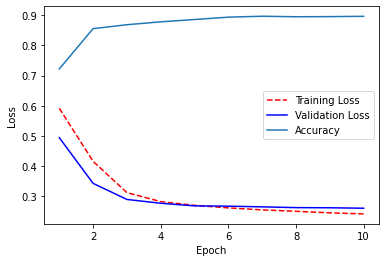

In [61]:
# Get training and test loss histories
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

accuracy = history.history['accuracy']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, validation_loss, 'b-')
plt.plot(epoch_count,accuracy)
plt.legend(['Training Loss', 'Validation Loss','Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

In [42]:
test_loss, test_accuracy = model.evaluate(test_inputs, test_targets)
print('\nTest loss: {0:.2f}. Test accuracy: {1:.2f}%'.format(test_loss, test_accuracy*100.))

19/19 [==============================] - 0s 2ms/step - loss: 0.3057 - accuracy: 0.8724

Test loss: 0.31. Test accuracy: 87.24%


In [43]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

In [44]:
predictions = probability_model.predict(test_inputs)

In [45]:
print(predictions[0])
print(test_targets[0])

[0.568011   0.43198904]
[1]


In [46]:
def plot_value_array(i, predictions_array, true_label):
    true_label = test_targets[i]
    plt.grid(False)

    thisplot = plt.bar(range(2), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)
    
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'
    
    plt.ylabel("{:2.0f}%".format(100*np.max(predictions_array),color=color))

    
    thisplot[predicted_label].set_color('red')
    thisplot[true_label[0]].set_color('blue')


In [ ]:
i = 105
plt.figure(figsize=(6,3))
plot_value_array(i, predictions[i],  test_targets)
plt.show()

In [ ]:
num_rows = 10
num_cols = 10
num_images = num_rows*num_cols

plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions[i], test_targets)
plt.tight_layout()
plt.show()

In [62]:
wrong_guess = []
for i in range(100):
    index = np.argmax(predictions[i])
    if(index!=test_targets[i]):
        wrong_guess.append(test_inputs[i])
        wrong.guess.append(test_targets[i])
        

In [ ]:
print(np.argmax(predictions[2]))
print(predictions[2])

In [ ]:
#Burde egentlig ha med alle feltene her(mangle 'target','weeks'?)
df = pd.DataFrame(wrong_guess)
df = df.rename(columns={0:'danceability',1:'energy',2:'key',3:'loudness',4:'mode',5:'speechiness',
       6:'acousticness',7:'instrumentalness',8:'liveness',9:'valence',10:'tempo',
       11:'duration_ms',12:'time_signature',13:'chorus_hit',14:'sections',
       15:'artist_popularity',16:'artist_followers'})


In [ ]:
sns.heatmap(df.corr())

In [ ]:
#Lav acousticness, speechness, instrumentalness, liveness, få followers
for i in df.columns:
    plt.hist(df[i])
    plt.title(i)
    plt.show()

In [ ]:
for i in df.columns:
    for j in df.columns:
        sns.scatterplot(x=i ,y=j, data =df)
        plt.show()